In [1]:
from __future__ import absolute_import, division, print_function

import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Show current TensorFlow version
print(tf.__version__)

2.0.0-alpha0



'2.0.0-alpha0'

In [87]:
data_dir = '/Users/nathenhuang/Downloads/'
training_file = data_dir + "/traffic-signs-data/train.p"
validation_file= data_dir + "/traffic-signs-data/valid.p"
testing_file = data_dir + "/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [88]:
signs = []
with open(data_dir+'traffic-signs-data/signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [89]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [90]:
X_train, y_train = shuffle(X_train, y_train)

In [91]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [92]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [93]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

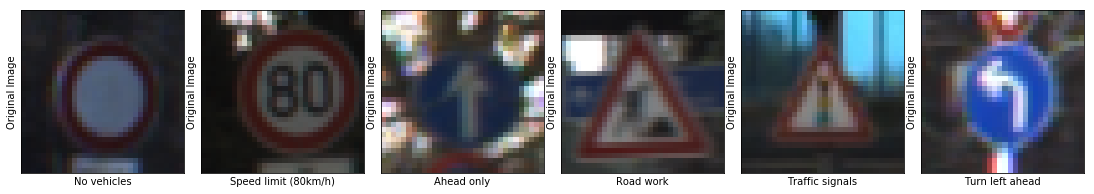

In [132]:
list_images(X_train, y_train, "Original Image", "gray")

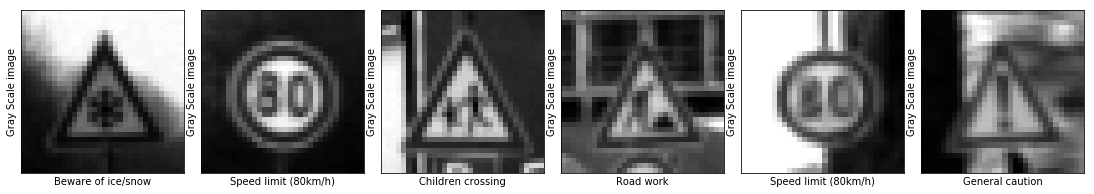

In [94]:
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

In [95]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

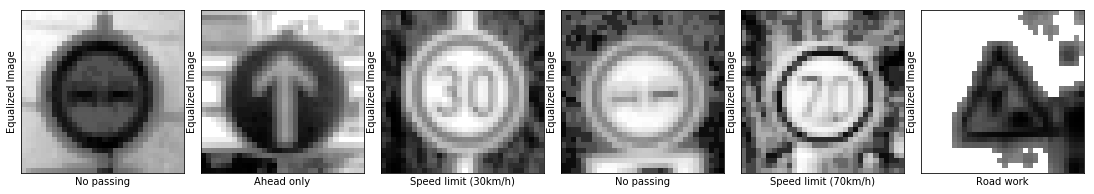

In [96]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

In [97]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

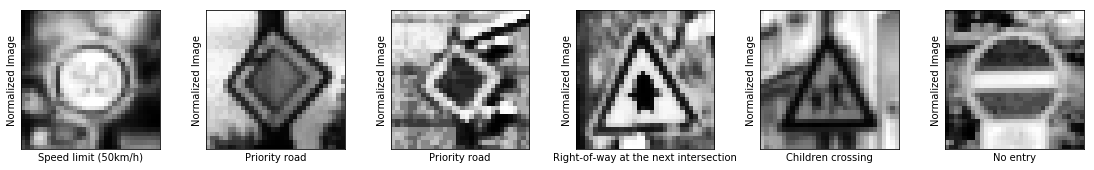

In [98]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [581]:
X_test_preprocessed = preprocess(X_test)
X_valid_preprocessed = preprocess(X_valid)

In [535]:
# Learning on non-privatized images

epochs = np.arange(5,25,5)
ndp_valid_accuracy = []
ndp_test_accuracy = []

for epoch in epochs: 
    
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.sigmoid),
    keras.layers.Dense(43, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(normalized_images[:,:,:,0], y_train, epochs=epoch)
    
    valid_loss, valid_acc = model.evaluate(X_valid_preprocessed[:,:,:,0], y_valid)
    test_loss, test_acc = model.evaluate(X_test_preprocessed[:,:,:,0], y_test)
    
    ndp_valid_accuracy.append(valid_acc)
    ndp_test_accuracy.append(test_acc)

Epoch 1/5
34799/34799 [==============================] - 5s 140us/sample - loss: 2.0892 - accuracy: 0.4397
Epoch 2/5
34799/34799 [==============================] - 5s 135us/sample - loss: 0.9473 - accuracy: 0.7368 - loss:
Epoch 3/5
34799/34799 [==============================] - 5s 134us/sample - loss: 0.6431 - accuracy: 0.8184
Epoch 4/5
34799/34799 [==============================] - 4s 129us/sample - loss: 0.4931 - accuracy: 0.8603
Epoch 5/5
12630/12630 [==============================] - 1s 65us/sample - loss: 0.9162 - accuracy: 0.7390
Epoch 1/10
34799/34799 [==============================] - 5s 135us/sample - loss: 2.0873 - accuracy: 0.4338
Epoch 2/10
34799/34799 [==============================] - 4s 125us/sample - loss: 0.9476 - accuracy: 0.7325
Epoch 3/10
34799/34799 [==============================] - 5s 142us/sample - loss: 0.6334 - accuracy: 0.8194
Epoch 4/10
34799/34799 [==============================] - 5s 150us/sample - loss: 0.5071 - accuracy: 0.8512
Epoch 5/10
34799/34799 [==

In [550]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.sigmoid),
    keras.layers.Dense(43, activation=tf.nn.softmax)
    ])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
history = model.fit(normalized_images[:,:,:,0], y_train, epochs=20)

Epoch 1/20
34799/34799 [==============================] - 6s 171us/sample - loss: 2.1969 - accuracy: 0.4067
Epoch 2/20
34799/34799 [==============================] - 4s 119us/sample - loss: 0.9825 - accuracy: 0.7269
Epoch 3/20
34799/34799 [==============================] - 4s 122us/sample - loss: 0.6498 - accuracy: 0.8145
Epoch 4/20
34799/34799 [==============================] - 4s 129us/sample - loss: 0.4933 - accuracy: 0.8607
Epoch 5/20
34799/34799 [==============================] - 5s 136us/sample - loss: 0.4110 - accuracy: 0.8802
Epoch 6/20
34799/34799 [==============================] - 5s 130us/sample - loss: 0.3633 - accuracy: 0.8942
Epoch 7/20
34799/34799 [==============================] - 4s 127us/sample - loss: 0.3097 - accuracy: 0.9089
Epoch 8/20
34799/34799 [==============================] - 4s 121us/sample - loss: 0.2889 - accuracy: 0.9149
Epoch 9/20
34799/34799 [==============================] - 4s 122us/sample - loss: 0.2458 - accuracy: 0.9272
Epoch 10/20
34799/34799 [===

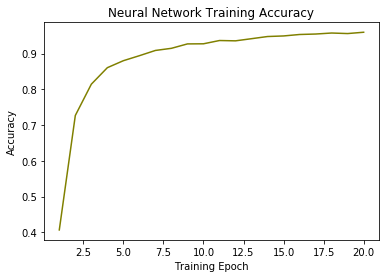

In [559]:
# plt.plot(np.arange(1,21,1), history_ndp.history['accuracy'], color='olive', linestyle='dashed')
plt.plot(np.arange(1,21,1), history.history['accuracy'], 'olive', label='Validation')
# plt.plot(epochs, ndp_test_accuracy, 'ro-', label = 'Test')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.title('Neural Network Training Accuracy')
# plt.legend(loc='lower right')
plt.show()

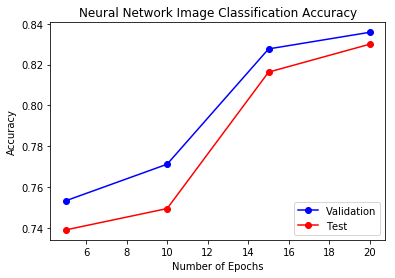

In [548]:
# plt.plot(np.arange(1,21,1), history_ndp.history['accuracy'], color='olive', linestyle='dashed')
plt.plot(epochs, ndp_valid_accuracy, 'bo-', label='Validation')
plt.plot(epochs, ndp_test_accuracy, 'ro-', label = 'Test')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.title('Neural Network Image Classification Accuracy')
plt.legend(loc='lower right')
plt.show()

In [469]:
# Learning on privatized images

delta = [10**-5, 10**-3, 10**-2, 0]
epsilon = [0, 0.01, 0.1, np.log(2), 5, 8, 10]

dp_acc_list = []
dp_test_list = []

n = 32

for d in delta: 

    for eps in epsilon:
        
        # Check the epsilon value to determine whether Laplace or Gaussian noise is added
        # Seen in dp-stats
        if eps == 0:
            noise = 0
        elif d == 0:
            noise = np.random.laplace(loc = 0, scale = 1/float(n*eps), size = (32,32))
        else:
            sigma = (1.0/(n*eps))*np.sqrt(2*np.log(1.25/d))
            noise = np.random.normal(0.0, sigma, size=(32,32))
        
        # Create a new list each loop of epsilon
        privatized = []
        
        # Add the noise to each record of the training set
        for i in range(len(normalized_images)):

            mat = normalized_images[i,:,:,0]

            privatized.append(np.array(mat + noise))
        
        # Fit the training model on the privatized data
        model = keras.Sequential([
        keras.layers.Flatten(input_shape=(32, 32)),
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(64, activation=tf.nn.sigmoid),
        keras.layers.Dense(43, activation=tf.nn.softmax)
        ])

        model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

        model.fit(np.array(privatized), y_train, epochs=20)
        
        # Compute the validation accuarcy and the test accuracy 
        valid_loss, valid_acc = model.evaluate(X_valid_preprocessed[:,:,:,0], y_valid)
        test_loss, test_acc = model.evaluate(X_test_preprocessed[:,:,:,0], y_test)
        
        dp_acc_list.append([d, eps, valid_acc])
        dp_test_list.append([d, eps, test_acc])

Epoch 1/20
34799/34799 [==============================] - 5s 130us/sample - loss: 2.1094 - accuracy: 0.4246
Epoch 2/20
34799/34799 [==============================] - 4s 114us/sample - loss: 0.9111 - accuracy: 0.7464
Epoch 3/20
34799/34799 [==============================] - 4s 106us/sample - loss: 0.6242 - accuracy: 0.8214
Epoch 4/20
34799/34799 [==============================] - 4s 102us/sample - loss: 0.4875 - accuracy: 0.8574
Epoch 5/20
34799/34799 [==============================] - 4s 104us/sample - loss: 0.4147 - accuracy: 0.8779
Epoch 6/20
34799/34799 [==============================] - 4s 104us/sample - loss: 0.3565 - accuracy: 0.8941
Epoch 7/20
34799/34799 [==============================] - 4s 116us/sample - loss: 0.3086 - accuracy: 0.9103
Epoch 8/20
34799/34799 [==============================] - 3s 99us/sample - loss: 0.2842 - accuracy: 0.9153
Epoch 9/20
34799/34799 [==============================] - 3s 97us/sample - loss: 0.2583 - accuracy: 0.9213
Epoch 10/20
34799/34799 [=====

34799/34799 [==============================] - 4s 103us/sample - loss: 0.2297 - accuracy: 0.9306
Epoch 12/20
34799/34799 [==============================] - 4s 102us/sample - loss: 0.2130 - accuracy: 0.9351
Epoch 13/20
34799/34799 [==============================] - 4s 109us/sample - loss: 0.2034 - accuracy: 0.9383
Epoch 14/20
34799/34799 [==============================] - 4s 107us/sample - loss: 0.1811 - accuracy: 0.9462
Epoch 15/20
34799/34799 [==============================] - 4s 106us/sample - loss: 0.1784 - accuracy: 0.9451
Epoch 16/20
34799/34799 [==============================] - 4s 108us/sample - loss: 0.1654 - accuracy: 0.9492
Epoch 17/20
34799/34799 [==============================] - 4s 108us/sample - loss: 0.1518 - accuracy: 0.9542
Epoch 18/20
34799/34799 [==============================] - 4s 107us/sample - loss: 0.1500 - accuracy: 0.9535
Epoch 19/20
34799/34799 [==============================] - 4s 103us/sample - loss: 0.1364 - accuracy: 0.9584
Epoch 20/20
12630/12630 [======

12630/12630 [==============================] - 1s 48us/sample - loss: 0.7254 - accuracy: 0.8381
Epoch 1/20
34799/34799 [==============================] - 5s 136us/sample - loss: 2.1787 - accuracy: 0.4098
Epoch 2/20
34799/34799 [==============================] - 4s 123us/sample - loss: 0.9998 - accuracy: 0.7097
Epoch 3/20
34799/34799 [==============================] - 5s 143us/sample - loss: 0.6794 - accuracy: 0.8018
Epoch 4/20
34799/34799 [==============================] - 4s 118us/sample - loss: 0.5314 - accuracy: 0.8425
Epoch 5/20
34799/34799 [==============================] - 5s 147us/sample - loss: 0.4355 - accuracy: 0.8728
Epoch 6/20
34799/34799 [==============================] - 4s 114us/sample - loss: 0.3840 - accuracy: 0.8848
Epoch 7/20
34799/34799 [==============================] - 4s 114us/sample - loss: 0.3225 - accuracy: 0.9042
Epoch 8/20
34799/34799 [==============================] - 4s 116us/sample - loss: 0.2949 - accuracy: 0.9118
Epoch 9/20
34799/34799 [================

34799/34799 [==============================] - 5s 140us/sample - loss: 0.2545 - accuracy: 0.9241
Epoch 10/20
34799/34799 [==============================] - 4s 113us/sample - loss: 0.2392 - accuracy: 0.9274
Epoch 11/20
34799/34799 [==============================] - 4s 125us/sample - loss: 0.2153 - accuracy: 0.9348
Epoch 12/20
34799/34799 [==============================] - 4s 101us/sample - loss: 0.2131 - accuracy: 0.9349
Epoch 13/20
34799/34799 [==============================] - 4s 101us/sample - loss: 0.1771 - accuracy: 0.9462
Epoch 14/20
34799/34799 [==============================] - 4s 101us/sample - loss: 0.1902 - accuracy: 0.9402
Epoch 15/20
34799/34799 [==============================] - 4s 111us/sample - loss: 0.1644 - accuracy: 0.9494
Epoch 16/20
34799/34799 [==============================] - 4s 111us/sample - loss: 0.1537 - accuracy: 0.9546
Epoch 17/20
34799/34799 [==============================] - 4s 108us/sample - loss: 0.1675 - accuracy: 0.9483
Epoch 18/20
34799/34799 [======

34799/34799 [==============================] - 4s 116us/sample - loss: 0.1279 - accuracy: 0.9615
Epoch 20/20
12630/12630 [==============================] - 1s 54us/sample - loss: 0.7706 - accuracy: 0.8196
Epoch 1/20
34799/34799 [==============================] - 4s 116us/sample - loss: 2.0949 - accuracy: 0.4306
Epoch 2/20
34799/34799 [==============================] - 4s 123us/sample - loss: 0.9377 - accuracy: 0.7375
Epoch 3/20
34799/34799 [==============================] - 4s 118us/sample - loss: 0.6280 - accuracy: 0.8217
Epoch 4/20
34799/34799 [==============================] - 4s 117us/sample - loss: 0.4986 - accuracy: 0.8578
Epoch 5/20
34799/34799 [==============================] - 4s 114us/sample - loss: 0.4225 - accuracy: 0.8789
Epoch 6/20
34799/34799 [==============================] - 4s 105us/sample - loss: 0.3529 - accuracy: 0.8982
Epoch 7/20
34799/34799 [==============================] - 4s 104us/sample - loss: 0.3168 - accuracy: 0.9068
Epoch 8/20
34799/34799 [===============

34799/34799 [==============================] - 4s 104us/sample - loss: 0.3289 - accuracy: 0.9032
Epoch 8/20
34799/34799 [==============================] - 4s 104us/sample - loss: 0.3013 - accuracy: 0.9099
Epoch 9/20
34799/34799 [==============================] - 4s 105us/sample - loss: 0.2577 - accuracy: 0.9236
Epoch 10/20
34799/34799 [==============================] - 4s 105us/sample - loss: 0.2391 - accuracy: 0.9259
Epoch 11/20
34799/34799 [==============================] - 4s 107us/sample - loss: 0.2271 - accuracy: 0.9294
Epoch 12/20
34799/34799 [==============================] - 4s 111us/sample - loss: 0.2053 - accuracy: 0.9389
Epoch 13/20
34799/34799 [==============================] - 4s 113us/sample - loss: 0.1872 - accuracy: 0.9430
Epoch 14/20
34799/34799 [==============================] - 4s 117us/sample - loss: 0.1869 - accuracy: 0.9429
Epoch 15/20
34799/34799 [==============================] - 4s 119us/sample - loss: 0.1721 - accuracy: 0.9469
Epoch 16/20
34799/34799 [========

34799/34799 [==============================] - 4s 124us/sample - loss: 0.1458 - accuracy: 0.9554
Epoch 18/20
34799/34799 [==============================] - 5s 139us/sample - loss: 0.1545 - accuracy: 0.9522
Epoch 19/20
34799/34799 [==============================] - 6s 166us/sample - loss: 0.1389 - accuracy: 0.9574
Epoch 20/20
12630/12630 [==============================] - 1s 51us/sample - loss: 0.7913 - accuracy: 0.8095
Epoch 1/20
34799/34799 [==============================] - 4s 120us/sample - loss: 2.1262 - accuracy: 0.4217
Epoch 2/20
34799/34799 [==============================] - 4s 126us/sample - loss: 0.9520 - accuracy: 0.7304
Epoch 3/20
34799/34799 [==============================] - 5s 152us/sample - loss: 0.6472 - accuracy: 0.8168
Epoch 4/20
34799/34799 [==============================] - 4s 117us/sample - loss: 0.4964 - accuracy: 0.8584
Epoch 5/20
34799/34799 [==============================] - 4s 126us/sample - loss: 0.4339 - accuracy: 0.8730
Epoch 6/20
34799/34799 [=============

34799/34799 [==============================] - 5s 145us/sample - loss: 0.4089 - accuracy: 0.8813
Epoch 6/20
34799/34799 [==============================] - 5s 130us/sample - loss: 0.3616 - accuracy: 0.8940
Epoch 7/20
34799/34799 [==============================] - 4s 119us/sample - loss: 0.3192 - accuracy: 0.9060
Epoch 8/20
34799/34799 [==============================] - 4s 115us/sample - loss: 0.2923 - accuracy: 0.9133
Epoch 9/20
34799/34799 [==============================] - 4s 126us/sample - loss: 0.2597 - accuracy: 0.9224
Epoch 10/20
34799/34799 [==============================] - 4s 129us/sample - loss: 0.2409 - accuracy: 0.9265
Epoch 11/20
34799/34799 [==============================] - 4s 125us/sample - loss: 0.2271 - accuracy: 0.9317
Epoch 12/20
34799/34799 [==============================] - 4s 121us/sample - loss: 0.2026 - accuracy: 0.9398
Epoch 13/20
34799/34799 [==============================] - 4s 115us/sample - loss: 0.1985 - accuracy: 0.9407
Epoch 14/20
34799/34799 [==========

34799/34799 [==============================] - 4s 123us/sample - loss: 0.1751 - accuracy: 0.9460
Epoch 16/20
34799/34799 [==============================] - 4s 114us/sample - loss: 0.1651 - accuracy: 0.9500
Epoch 17/20
34799/34799 [==============================] - 4s 124us/sample - loss: 0.1435 - accuracy: 0.9570
Epoch 18/20
34799/34799 [==============================] - 4s 117us/sample - loss: 0.1416 - accuracy: 0.9567
Epoch 19/20
34799/34799 [==============================] - 5s 138us/sample - loss: 0.1404 - accuracy: 0.9557
Epoch 20/20
12630/12630 [==============================] - 1s 62us/sample - loss: 0.7053 - accuracy: 0.8311


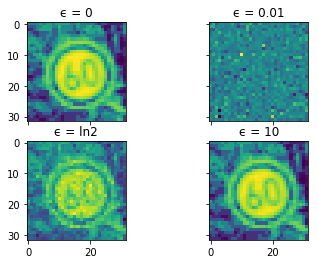

In [594]:
f, axarr = plt.subplots(2, 2)
# f.suptitle('Differentially Privatized Images')
axarr[0, 0].imshow(normalized_images[329,:,:,0])
axarr[0, 0].set_title('ϵ = 0')
axarr[0,1].imshow(normalized_images[329,:,:,0]+np.random.laplace(0,1/(32*0.01), size=(32,32)))
axarr[0,1].set_title('ϵ = 0.01')
axarr[1,0].imshow(normalized_images[329,:,:,0]+np.random.laplace(0,1/(32*np.log(2)), size=(32,32)))
axarr[1,0].set_title('ϵ = ln2')
axarr[1,1].imshow(normalized_images[329,:,:,0]+np.random.laplace(0,1/(32*10), size=(32,32)))
axarr[1,1].set_title('ϵ = 10')
for ax in axarr.flat:
    ax.label_outer()

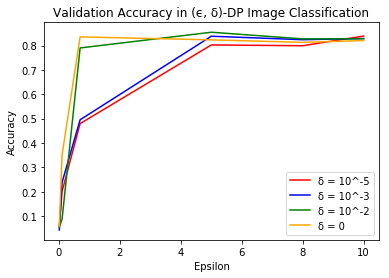

In [517]:
# plt.plot(np.arange(1,21,1), history_ndp.history['accuracy'], color='olive', linestyle='dashed')
plt.plot(epsilon[1:], pd.DataFrame(dp_acc_list, columns=['delta', 'eps', 'acc'])[pd.DataFrame(dp_acc_list, columns=['delta', 'eps', 'acc'])['delta'] == 10**-5]['acc'][1:], color='red', label='δ = 10^-5')
plt.plot(epsilon[1:], pd.DataFrame(dp_acc_list, columns=['delta', 'eps', 'acc'])[pd.DataFrame(dp_acc_list, columns=['delta', 'eps', 'acc'])['delta'] == 10**-3]['acc'][1:], color='blue', label='δ = 10^-3')
plt.plot(epsilon[1:], pd.DataFrame(dp_acc_list, columns=['delta', 'eps', 'acc'])[pd.DataFrame(dp_acc_list, columns=['delta', 'eps', 'acc'])['delta'] == 10**-2]['acc'][1:], color='green', label='δ = 10^-2')
plt.plot(epsilon[1:], pd.DataFrame(dp_acc_list, columns=['delta', 'eps', 'acc'])[pd.DataFrame(dp_acc_list, columns=['delta', 'eps', 'acc'])['delta'] == 0]['acc'][1:], color='orange', label='δ = 0')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.title('Validation Accuracy in (ϵ, δ)-DP Image Classification')
plt.legend(loc='lower right')
plt.show()

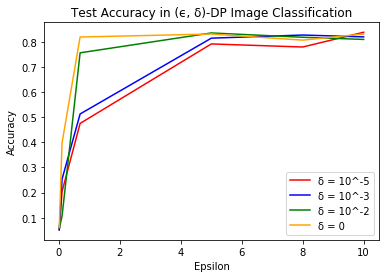

In [513]:
# plt.plot(np.arange(1,21,1), history_ndp.history['accuracy'], color='olive', linestyle='dashed')
plt.plot(epsilon[1:], pd.DataFrame(dp_test_list, columns=['delta', 'eps', 'acc'])[pd.DataFrame(dp_test_list, columns=['delta', 'eps', 'acc'])['delta'] == 10**-5]['acc'][1:], color='red', label='δ = 10^-5')
plt.plot(epsilon[1:], pd.DataFrame(dp_test_list, columns=['delta', 'eps', 'acc'])[pd.DataFrame(dp_test_list, columns=['delta', 'eps', 'acc'])['delta'] == 10**-3]['acc'][1:], color='blue', label='δ = 10^-3')
plt.plot(epsilon[1:], pd.DataFrame(dp_test_list, columns=['delta', 'eps', 'acc'])[pd.DataFrame(dp_test_list, columns=['delta', 'eps', 'acc'])['delta'] == 10**-2]['acc'][1:], color='green', label='δ = 10^-2')
plt.plot(epsilon[1:], pd.DataFrame(dp_test_list, columns=['delta', 'eps', 'acc'])[pd.DataFrame(dp_test_list, columns=['delta', 'eps', 'acc'])['delta'] == 0]['acc'][1:], color='orange', label='δ = 0')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.title('Test Accuracy in (ϵ, δ)-DP Image Classification')
plt.legend(loc='lower right')
plt.show()